In [1]:
import numpy as np
import pandas as pd
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
frame = pd.read_csv('/home/oneran/Downloads/jena_climate_2009_2016.csv')

In [2]:
frame

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [3]:
list = frame.keys()

In [4]:
list = list.delete(0)

In [5]:
temperature_data = frame[list].values

In [6]:
temperature_data.shape

(420451, 14)

In [7]:
from matplotlib import pyplot as plt

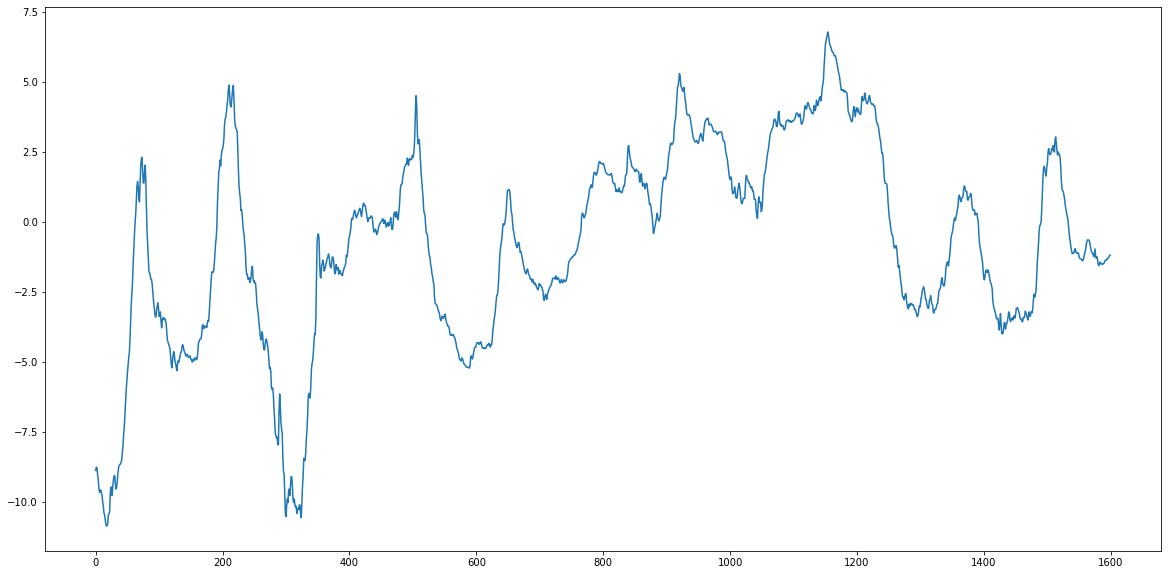

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(temperature_data[1600:3200, 1])

In [9]:
def data_normalization(data):
    data = data - np.mean(data, axis=0)
    data = data / np.std(data, axis=0)
    return data

In [10]:
data = data_normalization(temperature_data)

In [11]:
def generator(data, lookback, delay, min_index, max_index, steps=6, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - 1

    i = min_index + lookback
    while 1:
        if shuffle:     #若打乱的话
            rows = np.random.randint(
                min_index + lookback, max_index, batch_size     #从 mini_index + lookback 到 max_index 中随机挑选batch_size 个整数
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                rows = np.arange(i, min(i + batch_size, max_index))
                i += len(rows)
        
        samples = np.zeros((len(rows), lookback // steps, data.shape[-1]))
        targets = np.zeros(len(rows))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], steps)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay, 1]
        yield samples, targets


In [12]:
train_gen = generator(data, lookback=1440, delay=144, min_index=0, max_index=200000, shuffle=True, steps=6)
val_gen = generator(data, lookback=1440, delay=144, min_index=200001, max_index=300000, shuffle=True, steps=6)
test_gen = generator(data, lookback=1440, delay=144, min_index=300001, max_index=400000, shuffle= True, steps=6)

val_steps = (100000-1440) // 6
test_steps = (100000-1440) // 6

In [13]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        sample, target = next(val_gen)
        preds = sample[:, -1, 1]
        mae = np.mean(np.abs(preds - target))
        batch_maes.append(mae)

    return np.mean(batch_maes)

In [14]:
# mae = evaluate_naive_method()

In [15]:

from tensorflow.keras import layers, models, optimizers
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1 import ConfigProto, Session
import tensorflow.keras
config = ConfigProto(allow_soft_placement=True)

config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(Session(config=config))

In [16]:
model = models.Sequential()
model.add(
    layers.GRU(32, input_shape=(None, data.shape[-1]))
)
model.add(
    layers.Dense(1)
)

model.compile(
    optimizer=optimizers.RMSprop(),
    loss='mae',
    metrics=['mae']
)

In [17]:
history = model.fit_generator(
    train_gen,
    epochs=20,
    steps_per_epoch=500,
    validation_data=val_gen,
    validation_steps=500
)

Epoch 1/20
500/500 [==============================] - 14s 19ms/step - loss: 0.3246 - mae: 0.3246 - val_loss: 0.2860 - val_mae: 0.2860
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3007 - mae: 0.3007 - val_loss: 0.2766 - val_mae: 0.2766
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2934 - mae: 0.2934 - val_loss: 0.2805 - val_mae: 0.2805
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2850 - mae: 0.2850 - val_loss: 0.2775 - val_mae: 0.2775
Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2863 - mae: 0.2863 - val_loss: 0.2765 - val_mae: 0.2765
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2793 - mae: 0.2793 - val_loss: 0.2769 - val_mae: 0.2769
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2738 - mae: 0.2738 - val_loss: 0.2839 - val_mae: 0.2839
Epoch 8/20
500/500 [==============================] - 10s 21ms/ste

In [18]:
# prediction = model.predict_generator(
#     test_gen,
#     steps=test_steps
# )

构建一个 有Dropout的循环神经网络


In [21]:
model = models.Sequential()
model.add(
    layers.GRU(32, input_shape=(None, data.shape[-1]), dropout=0.2, recurrent_dropout=0.2)
)
model.add(
    layers.Dense(1)
)
model.compile(
    loss='mae',
    metrics=['mae'],
    optimizer=optimizers.RMSprop()
)

In [22]:
history = model.fit_generator(
    train_gen,
    epochs=40,
    steps_per_epoch=500,
    validation_data=val_gen,
    validation_steps=500
)

Epoch 1/40
500/500 [==============================] - 20s 29ms/step - loss: 0.3785 - mae: 0.3785 - val_loss: 0.2909 - val_mae: 0.2909
Epoch 2/40
500/500 [==============================] - 15s 30ms/step - loss: 0.3215 - mae: 0.3215 - val_loss: 0.2877 - val_mae: 0.2877
Epoch 3/40
500/500 [==============================] - 14s 28ms/step - loss: 0.3114 - mae: 0.3114 - val_loss: 0.2850 - val_mae: 0.2850
Epoch 4/40
500/500 [==============================] - 14s 28ms/step - loss: 0.3107 - mae: 0.3107 - val_loss: 0.2853 - val_mae: 0.2853
Epoch 5/40
500/500 [==============================] - 14s 29ms/step - loss: 0.3045 - mae: 0.3045 - val_loss: 0.2925 - val_mae: 0.2925
Epoch 6/40
500/500 [==============================] - 14s 29ms/step - loss: 0.3015 - mae: 0.3015 - val_loss: 0.2886 - val_mae: 0.2886
Epoch 7/40
500/500 [==============================] - 14s 29ms/step - loss: 0.2954 - mae: 0.2954 - val_loss: 0.2895 - val_mae: 0.2895
Epoch 8/40
500/500 [==============================] - 14s 28ms

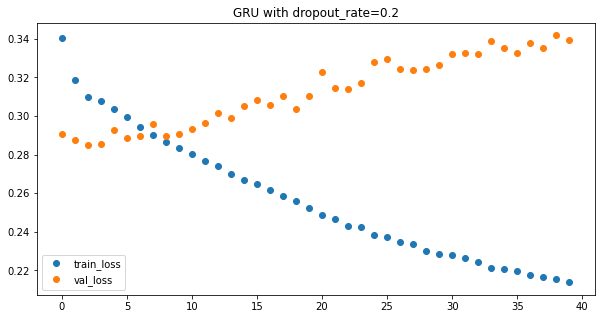

In [29]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,5))
plt.title('GRU with dropout_rate=0.2')
plt.plot(train_loss, 'o')
plt.plot(val_loss, 'o')
plt.legend(['train_loss','val_loss'])

In [30]:
model = models.Sequential()
model.add(
    layers.GRU(32, input_shape=(None, data.shape[-1]), dropout=0.2, recurrent_dropout=0.2)
)
model.add(
    layers.Dense(1)
)
model.compile(
    loss='mae',
    metrics=['mae'],
    optimizer=optimizers.RMSprop()
)

In [32]:
history = model.fit_generator(
    train_gen,
    epochs=40,
    steps_per_epoch=500,
    validation_data=val_gen,
    validation_steps=500
)

Epoch 1/40
500/500 [==============================] - 281s 563ms/step - loss: 0.3484 - mae: 0.3484 - val_loss: 0.2913 - val_mae: 0.2913
Epoch 2/40
500/500 [==============================] - 307s 614ms/step - loss: 0.3234 - mae: 0.3234 - val_loss: 0.2877 - val_mae: 0.2877
Epoch 3/40
500/500 [==============================] - 189s 377ms/step - loss: 0.3142 - mae: 0.3142 - val_loss: 0.2916 - val_mae: 0.2916
Epoch 4/40
500/500 [==============================] - 162s 324ms/step - loss: 0.3081 - mae: 0.3081 - val_loss: 0.2910 - val_mae: 0.2910
Epoch 5/40
500/500 [==============================] - 162s 325ms/step - loss: 0.3019 - mae: 0.3019 - val_loss: 0.2806 - val_mae: 0.2806
Epoch 6/40
500/500 [==============================] - 193s 387ms/step - loss: 0.2978 - mae: 0.2978 - val_loss: 0.2834 - val_mae: 0.2834
Epoch 7/40
500/500 [==============================] - 213s 425ms/step - loss: 0.2909 - mae: 0.2909 - val_loss: 0.2828 - val_mae: 0.2828
Epoch 8/40
500/500 [============================

Text(0.5, 1.0, 'GRU with_recurrent_dropout_0.2 and dropout_0.2')

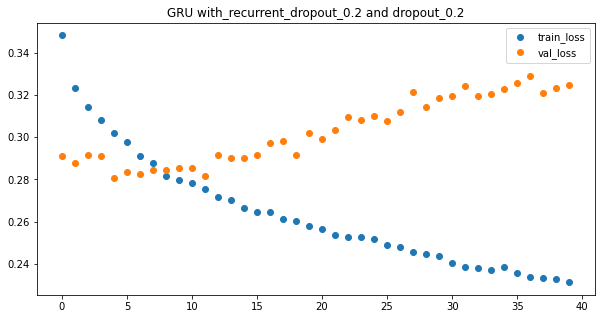

In [34]:
train_loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss_1, 'o')
plt.plot(val_loss_1, 'o')
plt.legend(['train_loss', 'val_loss'])
plt.title('GRU with_recurrent_dropout_0.2 and dropout_0.2')